## 1. Import Python libraries
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_412/img/92_notebook.jpg" alt="honey bee">
<em>A honey bee (Apis).</em></p>
<p>Can a machine identify a bee as a honey bee or a bumble bee? These bees have different <a href="https://www.thesca.org/connect/blog/bumblebees-vs-honeybees-what%E2%80%99s-difference-and-why-does-it-matter">behaviors and appearances</a>, but given the variety of backgrounds, positions, and image resolutions, it can be a challenge for machines to tell them apart.</p>
<p>Being able to identify bee species from images is a task that ultimately would allow researchers to more quickly and effectively collect field data. Pollinating bees have critical roles in both ecology and agriculture, and diseases like <a href="http://news.harvard.edu/gazette/story/2015/07/pesticide-found-in-70-percent-of-massachusetts-honey-samples/">colony collapse disorder</a> threaten these species. Identifying different species of bees in the wild means that we can better understand the prevalence and growth of these important insects.</p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_412/img/20_notebook.jpg" alt="bumble bee">
<em>A bumble bee (Bombus).</em></p>
<p>After loading and pre-processing images, this notebook walks through building a model that can automatically detect honey bees and bumble bees.</p>

In [1]:
# used to change filepaths
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

# import Image from PIL
from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# import train_test_split from sklearn's model selection module
from sklearn.model_selection import train_test_split

# import SVC from sklearn's svm module
from sklearn.svm import SVC

# import accuracy_score from sklearn's metrics module
from sklearn.metrics import roc_curve, auc, accuracy_score

## 2. Display image of each bee type
<p>Now that we have all of our imports ready, it is time to look at some images. We will load our <code>labels.csv</code> file into a dataframe called <code>labels</code>, where the index is the image name (e.g. an index of 1036 refers to an image named 1036.jpg) and the <code>genus</code> column tells us the bee type. <code>genus</code> takes the value of either <code>0.0</code> (Apis or honey bee) or <code>1.0</code> (Bombus or bumble bee).</p>
<p>The function <code>get_image</code> converts an index value from the dataframe into a file path where the image is located, opens the image using the <a href="https://pillow.readthedocs.io/en/5.1.x/reference/Image.html">Image</a> object in Pillow, and then returns the image as a numpy array.</p>
<p>We'll use this function to load the sixth Apis image and then the sixth Bombus image in the dataframe.</p>

,genus
id,
520,1.0
3800,1.0
3289,1.0
2695,1.0
4922,1.0


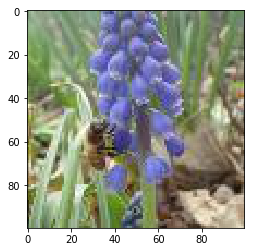

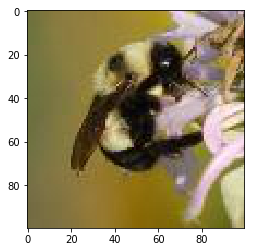

In [2]:
# load the labels using pandas
labels = pd.read_csv("datasets/labels.csv", index_col=0)

# show the first five rows of the dataframe using head
display(labels.head())

def get_image(row_id, root="datasets/"):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)

# subset the dataframe to just Apis (genus is 0.0) get the value of the sixth item in the index
apis_row = labels[labels.genus == 0.0].index[5]

# show the corresponding image of an Apis
plt.imshow(get_image(apis_row))
plt.show()

# subset the dataframe to just Bombus (genus is 1.0) get the value of the sixth item in the index
bombus_row = labels[labels.genus == 1.0].index[5]

# show the corresponding image of a Bombus
plt.imshow(get_image(bombus_row))
plt.show()

## 3. Image manipulation with rgb2grey
<p>scikit-image has a number of image processing functions built into the library, for example, converting an image to greyscale. The <a href="http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2grey"><code>rgb2grey</code></a> function computes the luminance of an RGB image using the following formula <code>Y = 0.2125 R + 0.7154 G + 0.0721 B</code>. </p>
<p>Image data is represented as a matrix, where the depth is the number of channels. An RGB image has three channels (red, green, and blue) whereas the returned greyscale image has only one channel. Accordingly, the original color image has the dimensions <code>100x100x3</code> but after calling <code>rgb2grey</code>, the resulting greyscale image has only one channel, making the dimensions <code>100x100x1</code>.</p>

Color bombus image has shape:  (100, 100, 3)
Greyscale bombus image has shape:  (100, 100)


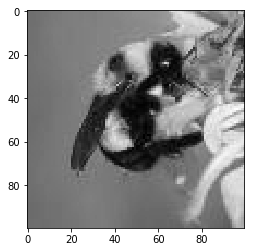

In [3]:
# load a bombus image using our get_image function and bombus_row from the previous cell
bombus = get_image(bombus_row)

# print the shape of the bombus image
print('Color bombus image has shape: ', bombus.shape)

# convert the bombus image to greyscale
grey_bombus = rgb2grey(bombus)

# show the greyscale image
plt.imshow(grey_bombus, cmap=mpl.cm.gray)

# greyscale bombus image only has one channel
print('Greyscale bombus image has shape: ', grey_bombus.shape)

## 4. Histogram of oriented gradients
<p>Now we need to turn these images into something that a machine learning algorithm can understand. Traditional computer vision techniques have relied on mathematical transforms to turn images into useful features. For example, you may want to detect edges of objects in an image, increase the contrast, or filter out particular colors.</p>
<p>We've got a matrix of pixel values, but those don't contain enough interesting information on their own for most algorithms. We need to help the algorithms along by picking out some of the salient features for them using the <a href="http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html">histogram of oriented gradients</a> (HOG) descriptor. The idea behind <a href="https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients">HOG</a> is that an object's shape within an image can be inferred by its edges, and a way to identify edges is by looking at the direction of intensity gradients (i.e. changes in luminescence). </p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_412/img/hog.png" alt="HOG"></p>
<p>An image is divided in a grid fashion into cells, and for the pixels within each cell, a histogram of gradient directions is compiled. To improve invariance to highlights and shadows in an image, cells are block normalized, meaning an intensity value is calculated for a larger region of an image called a block and used to contrast normalize all cell-level histograms within each block. The HOG feature vector for the image is the concatenation of these cell-level histograms.</p>

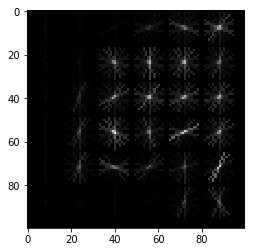

In [4]:
# run HOG using our greyscale bombus image
hog_features, hog_image = hog(grey_bombus,
                              visualise=True, #visualize in newer versions
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

# show our hog_image with a grey colormap
plt.imshow(hog_image, cmap=mpl.cm.gray)

## 5. Create image features and flatten into a single row
<p>Algorithms require data to be in a format where rows correspond to images and columns correspond to features. This means that all the information for a given image needs to be contained in a single row.</p>
<p>We want to provide our model with the raw pixel values from our images as well as the HOG features we just calculated. To do this, we will write a function called <code>create_features</code> that combines these two sets of features by flattening the three-dimensional array into a one-dimensional (flat) array.</p>

In [5]:
def create_features(img):
    # flatten three channel color image
    color_features = np.ndarray.flatten(img)
    # convert image to greyscale
    grey_image = rgb2grey(img)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack([color_features, hog_features])
    return flat_features

bombus_features = create_features(bombus)

# print shape of bombus_features
bombus_features.shape

(31296,)

## 6. Loop over images to preprocess
<p>Above we generated a flattened features array for the bombus image. Now it's time to loop over all of our images. We will create features for each image and then stack the flattened features arrays into a big matrix we can pass into our model.</p>
<p>In the <code>create_feature_matrix</code> function, we'll do the following:</p>
<ul>
<li>Load an image</li>
<li>Generate a row of features using the <code>create_features</code> function above</li>
<li>Stack the rows into a features matrix</li>
</ul>
<p>In the resulting features matrix, rows correspond to images and columns to features.</p>

In [6]:
def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.index:
        # load image
        img = get_image(img_id)
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(labels)
feature_matrix

array([[124.        , 118.        ,  84.        , ...,   1.27950416,
          0.91917773,   1.26859675],
       [ 46.        ,  43.        ,  24.        , ...,   0.45680134,
          0.48090239,   0.85734347],
       [167.        , 188.        , 113.        , ...,   0.42707375,
          0.53334856,   0.71093329],
       ...,
       [  5.        ,  42.        ,   1.        , ...,   1.18298755,
          1.30305053,   0.70130099],
       [249.        , 226.        , 172.        , ...,   0.86338232,
          0.40147662,   0.39136725],
       [132.        , 143.        ,  74.        , ...,   0.96360601,
          1.10322679,   1.77341567]])

## 7. Scale feature matrix + PCA
<p>Our features aren't quite done yet. Many machine learning methods are built to work best with data that has a mean of 0 and unit variance. Luckily, scikit-learn <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">provides a simple way</a> to rescale your data to work well using <code>StandardScaler</code>. They've got a more thorough explanation of why that is in the linked docs.</p>
<p>Remember also that we have over 31,000 features for each image and only 500 images total. To use an SVM, our model of choice, we also need to reduce the number of features we have using <a href="http://scikit-learn.org/stable/modules/decomposition.html#pca">principal component analysis</a> (PCA). </p>
<p>PCA is a way of linearly transforming the data such that most of the information in the data is contained within a smaller number of features called components. Below is a visual <a href="https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60">example</a> from an image dataset containing handwritten numbers. The image on the left is the original image with 784 components. We can see that the image on the right (post PCA) captures the shape of the number quite effectively even with only 59 components.</p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_412/img/pca_cropped.png" alt="PCA"></p>
<p>In our case, we will keep 500 components. This means our feature matrix will only have 500 columns rather than the original 31,296.</p>

In [7]:
# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
bees_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
bees_pca = pca.fit_transform(bees_stand)
# look at new shape
print('PCA matrix shape is: ', bees_pca.shape)

Feature matrix shape is:  (500, 31296)
PCA matrix shape is:  (500, 500)


## 8. Split into train and test sets
<p>Now we need to convert our data into train and test sets. We'll use 70% of images as our training data and test our model on the remaining 30%. Scikit-learn's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html"><code>train_test_split</code></a> function makes this easy.</p>

In [8]:
X_train, X_test, y_train, y_test = train_test_split(bees_pca,
                                                    labels.genus.values,
                                                    test_size=.3,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

0.0    175
1.0    175
dtype: int64

## 9. Train model
<p>It's finally time to build our model! We'll use a <a href="http://scikit-learn.org/stable/modules/svm.html">support vector machine</a> (SVM), a type of supervised machine learning model used for regression, classification, and outlier detection." An <a href="https://en.wikipedia.org/wiki/Support_vector_machine">SVM model</a> is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall."</p>
<p>Here's a visualization of the maximum margin separating two classes using an SVM classifier with a linear kernel.
<img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_412/img/svm_cropped.png" alt="SVM"></p>
<p>Since we have a classification task -- honey or bumble bee -- we will use the support vector classifier (SVC), a type of SVM. We imported this class at the top of the notebook.</p>

In [9]:
# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=42)

# fit model
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

## 10. Score model
<p>Now we'll use our trained model to generate predictions for our test data. To see how well our model did, we'll calculate the accuracy by comparing our predicted labels for the test set with the true labels in the test set. Accuracy is the number of correct predictions divided by the total number of predictions. Scikit-learn's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html"><code>accuracy_score</code></a> function will do math for us. Sometimes accuracy can be misleading, but since we have an equal number of honey and bumble bees, it is a useful metric for this problem.</p>

In [10]:
# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.7


## 11. ROC curve + AUC
<p>Above, we used <code>svm.predict</code> to predict either <code>0.0</code> or <code>1.0</code> for each image in <code>X_test</code>. Now, we'll use <code>svm.predict_proba</code> to get the probability that <strong>each class</strong> is the true label. For example, <code>predict_proba</code> returns <code>[0.46195176, 0.53804824]</code> for the first image, meaning there is a 46% chance the bee in the image is an Apis (<code>0.0</code>) and a 53% chance the bee in the image is a Bombus (<code>1.0</code>). Note that the two probabilities for each image always sum to 1. </p>
<p>Using the default settings, probabilities of 0.5 or above are assigned a class label of <code>1.0</code> and those below are assigned a <code>0.0</code>. However, this threshold can be adjusted. The <a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic">receiver operating characteristic curve</a> (ROC curve) plots the false positive rate and true positive rate at different thresholds. ROC curves are judged visually by how close they are to the upper lefthand corner. </p>
<p>The <a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve">area under the curve</a> (AUC) is also calculated, where 1 means every predicted label was correct. Generally, the worst score for AUC is 0.5, which is the performance of a model that randomly guesses. See the scikit-learn documentation for more resources and examples on <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html">ROC curves</a> and <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html">AUC</a>.</p>

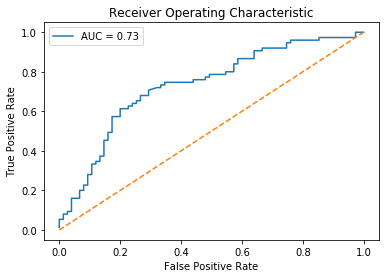

In [11]:
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');